## Strategy on Earnings forecast oscillator

this strategy computes the change between actual eps and the time series forecast

It is very simple and do not use consensus estimate for eps

The Forecast Oscillator calculates the percentage difference between the actual
price and the Time Series Forecast (the endpoint of a linear regression line).

The signal goes long (short)  stocks with the biggest (smallest) change forecast

In [19]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import numpy as np
from numpy.core.numeric import normalize_axis_tuple
from numpy.core.overrides import array_function_dispatch, set_module
import matplotlib.pyplot as plt
from tqdm import tqdm
market_data = pd.read_parquet('data/US/test_mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/test_balance_sheet.pq')
earnings = pd.read_parquet('data/US/test_earnings.pq')
income_statement = pd.read_parquet('data/US/test_income_statement.pq')
cash_flow = pd.read_parquet('data/US/test_cash_flow.pq')
GICS = pd.read_parquet('data/US/test_GICS.pq')
P = pd.read_parquet('data/US/test_universe_table.pq')
P.index.names = ['Date']
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

In [21]:

earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_actual = eps_actual[P].rank(1,pct=True,ascending=True).clip(0.01,0.99)

<Axes: xlabel='Date'>

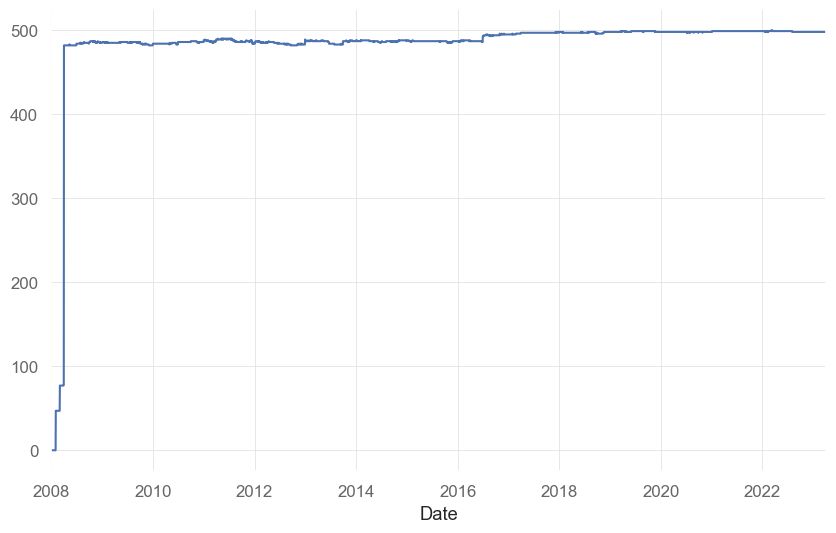

In [22]:
eps_actual.count(1).plot()

In [23]:
earnings.xs('A',level=1).tail(4)
### accurate but small differences with https://www.nasdaq.com/market-activity/stocks/a/earnings
#more generally we remark almost of all the time correct report date, but we're  still data source dependent


,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,,,,,,,,
2023-04-30,2023-05-23,2023-04-30,AfterMarket,USD,1.27,1.26,0.01,0.7937
2023-07-31,2023-08-15,2023-07-31,AfterMarket,USD,1.43,1.36,0.07,5.1471
2023-10-31,2023-11-20,2023-10-31,AfterMarket,USD,1.38,1.34,0.04,2.9851
2024-01-31,2024-02-27,2024-01-31,AfterMarket,USD,1.29,1.22,0.07,5.7377


In [24]:
earnings.xs('UNH',level=1).tail(4)
### accurate but small differences with https://www.nasdaq.com/market-activity/stocks/unh/earnings


,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,,,,,,,,
2023-03-31,2023-04-14,2023-03-31,BeforeMarket,None,6.26,6.13,0.13,2.1207
2023-06-30,2023-07-14,2023-06-30,BeforeMarket,None,6.14,5.99,0.15,2.5042
2023-09-30,2023-10-13,2023-09-30,BeforeMarket,None,6.56,6.32,0.24,3.7975
2023-12-31,2024-01-12,2023-12-31,BeforeMarket,None,6.16,5.98,0.18,3.0100


In [25]:
import numpy as np
from numpy.core.numeric import normalize_axis_tuple
from numpy.core.overrides import array_function_dispatch, set_module

__all__ = ['broadcast_to', 'broadcast_arrays', 'broadcast_shapes']


class DummyArray:
    """Dummy object that just exists to hang __array_interface__ dictionaries
    and possibly keep alive a reference to a base array.
    """

    def __init__(self, interface, base=None):
        self.__array_interface__ = interface
        self.base = base



def _maybe_view_as_subclass(original_array, new_array):
    if type(original_array) is not type(new_array):
        # if input was an ndarray subclass and subclasses were OK,
        # then view the result as that subclass.
        new_array = new_array.view(type=type(original_array))
        # Since we have done something akin to a view from original_array, we
        # should let the subclass finalize (if it has it implemented, i.e., is
        # not None).
        if new_array.__array_finalize__:
            new_array.__array_finalize__(original_array)
    return new_array

In [26]:
def as_strided(x, shape=None, strides=None, subok=False, writeable=True):

    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)
    interface = dict(x.__array_interface__)
    if shape is not None:
        interface['shape'] = tuple(shape)
    if strides is not None:
        interface['strides'] = tuple(strides)

    array = np.asarray(DummyArray(interface, base=x))
    # The route via `__interface__` does not preserve structured
    # dtypes. Since dtype should remain unchanged, we set it explicitly.
    array.dtype = x.dtype

    view = _maybe_view_as_subclass(x, array)

    if view.flags.writeable and not writeable:
        view.flags.writeable = False

    return view

In [27]:
def sliding_window_view(x, window_shape, axis=None, *,
                        subok=False, writeable=False):
    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)


In [28]:
def linreg(close, length=None, offset=None, **kwargs):
    
    """Indicator: Linear Regression"""
    # Validate arguments
    length = int(length) if length and length > 0 else 14
    angle = kwargs.pop("angle", False)
    intercept = kwargs.pop("intercept", False)
    r = kwargs.pop("r", False)
    slope = kwargs.pop("slope", False)
    tsf = kwargs.pop("tsf", False)
    offset = int(offset) if offset else 0

    if close is None: return

    # Calculate Result
    x = range(1, length + 1)
    x_sum = 0.5 * length * (length + 1)
    x2_sum = x_sum * (2 * length + 1) / 3
    divisor = length * x2_sum - x_sum * x_sum

    def linear_regression(series):
        y_sum = series.sum()
        xy_sum = (x * series).sum()

        m = (length * xy_sum - x_sum * y_sum) / divisor
        if slope:
            return m
        b = (y_sum * x2_sum - x_sum * xy_sum) / divisor
        if intercept:
            return b

        if r:
            y2_sum = (series * series).sum()
            rn = length * xy_sum - x_sum * y_sum
            rd = (divisor * (length * y2_sum - y_sum * y_sum)) ** 0.5
            return rn / rd

        return m * length + b if tsf else m * (length - 1) + b


    from numpy.lib.stride_tricks import sliding_window_view
    linreg_ = [linear_regression(_) for _ in sliding_window_view(np.array(close), length)]


    linreg = pd.Series([np.nan] * (length - 1) + linreg_, index=close.index)

    # Offset
    if offset != 0:
        linreg = linreg.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        linreg.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        linreg.fillna(method=kwargs["fill_method"], inplace=True)

    # Name and Categorize it
    linreg.name = f"LR"
    if slope: linreg.name += "m"
    if intercept: linreg.name += "b"
    if angle: linreg.name += "a"
    if r: linreg.name += "r"

    linreg.name += f"_{length}"
    linreg.category = "overlap"

    return linreg


In [29]:
def forecast_oscillator(close, length=None, scalar=None, drift=None, offset=None, **kwargs):
    """Indicator: Chande Forcast Oscillator (CFO)"""
    # Validate Arguments
    length = int(length) if length and length > 0 else 9
    scalar = float(scalar) if scalar else 100
    drift = drift if drift else 1
    offset = offset if offset else 0

    if close is None: return

    # Finding linear regression of Series
    change_forecast = scalar * (close - linreg(close, length=length, tsf=True,angle=True))
    change_forecast /= close

    # Offset
    if offset != 0:
        change_forecast = change_forecast.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        change_forecast.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        change_forecast.fillna(method=kwargs["fill_method"], inplace=True)

    return change_forecast

In [30]:
eps =  earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float).rank(1,pct=True,ascending=True)
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    try :
        metrics = forecast_oscillator(eps[ticker],length=5).fillna(0)
        results[ticker] = metrics

    except :
        print(ticker)
metrics = pd.concat(results,axis=1).reindex_like(P).ffill()


100%|██████████| 879/879 [01:45<00:00,  8.32it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_21728\4250172003.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe                    -0.4
Daily Turnover (%)        21.8
biais (bp)                -0.3
Sharpe since 2022         -0.4
biais  since 2022 (bp)    -0.3
dtype: float64

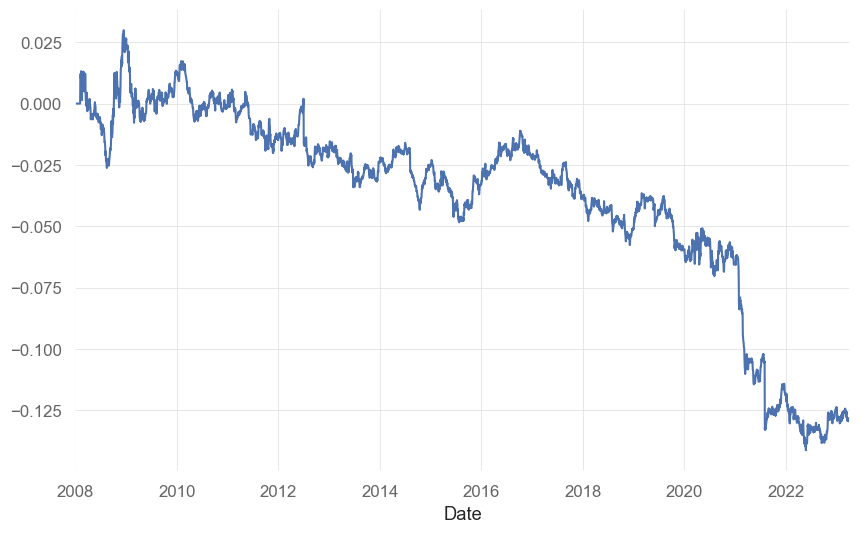

In [33]:
signal = metrics[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<1] = 0

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)

<Axes: >

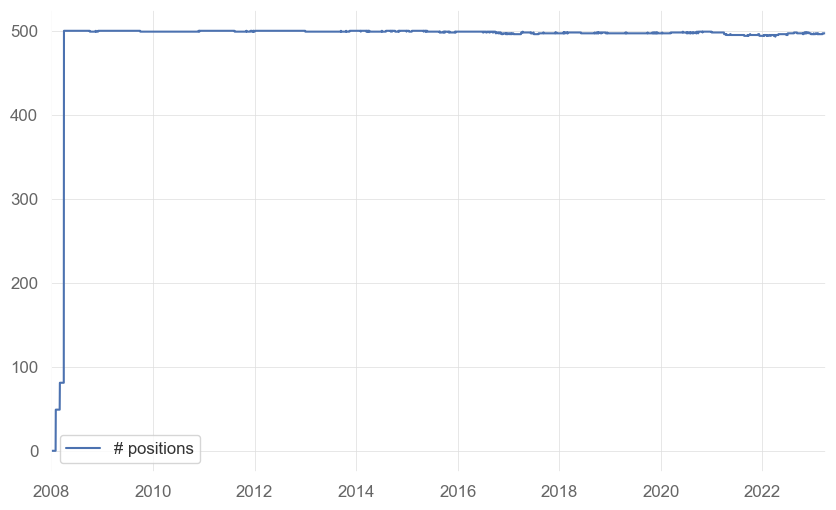

In [14]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

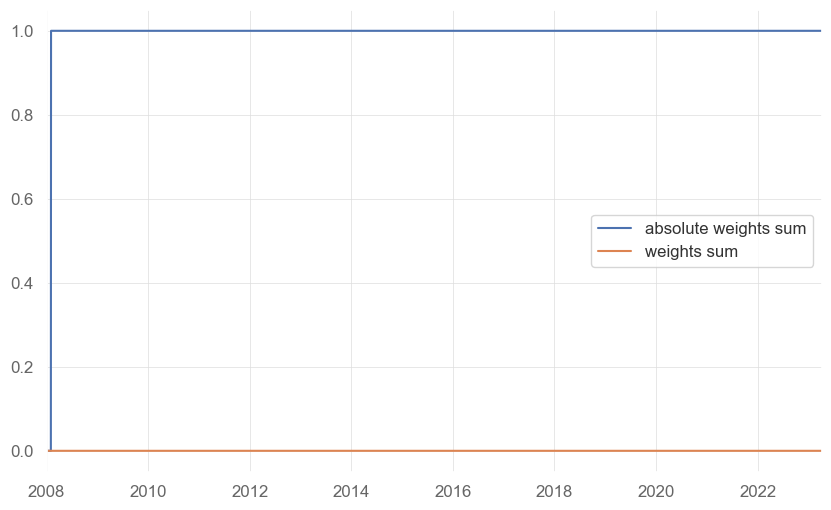

In [15]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)

In [16]:
import quantstats as qs
SP500 = qs.utils.download_returns('SPY')

# report with fancy (and some unuseful) stats
qs.reports.html(PNL, "SPY",title = 'Strategy EPS Linreg')

c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


In [18]:
PNL.to_csv('data/US/strat_eps_cfo_pnl.csv')

In [2]:
import pandas_ta as ta

ta.mom()

TypeError: cti() missing 1 required positional argument: 'close'